In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
from nnfabrik.builder import get_data


from mypkg.visualization import LivePlot

import csng
from csng.GAN import GAN
from csng.utils import plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop
from csng.data import MixedBatchLoader

from models import MultiReadIn, ConvReadIn
from data_utils import get_mouse_v1_data, PerSampleStoredDataset

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 16,
        "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
})

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config)

Training dataset:	 22414 samples
Validation dataset:	 2527 samples
Test dataset:		 4984 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.699  max=2.261
  mean=0.203  std=1.022
responses:
  torch.Size([7, 8372])
  min=-0.000  max=21.945
  mean=0.350  std=1.020
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


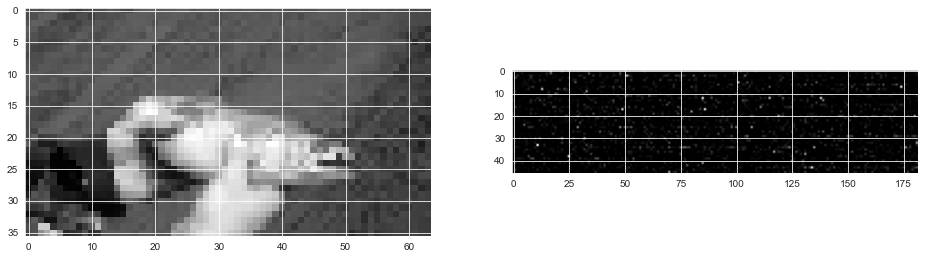

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["val"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if resp.shape[-1] % i == 0:
        reshape_to = (i, resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [8]:
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    "data_key_prefix": "syn",
}

In [9]:
def append_syn_dataloaders(dataloaders, config):
    for data_key in config["data_keys"]:
        ### divide by the per neuron std if the std is greater than 1% of the mean std (to avoid division by 0)
        resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"responses_std_original.npy"))).float()
        div_by = resp_std.clone()
        thres = 0.01 * resp_std.mean()
        idx = resp_std <= thres
        div_by[idx] = thres

        data_key_to_add = data_key if config["data_key_prefix"] is None else f"{config['data_key_prefix']}_{data_key}"
        neuron_coords = {
            data_key_to_add: torch.from_numpy(np.load(
                os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"neuron_coords.npy")
            )).float()
        }

        for data_part in config["append_data_parts"]:
            dataloader = DataLoader(
                PerSampleStoredDataset(
                    dataset_dir=os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, data_part),
                    stim_transform=lambda x: x,
                    # resp_transform=csng.utils.Normalize(
                    #     mean=torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", target_data_key, f"responses_mean_original.npy"))).float(),
                    #     std=torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", target_data_key, f"responses_std_original.npy"))).float()
                    # ),
                    resp_transform=csng.utils.Normalize(
                        mean=0,
                        std=div_by,
                    ),
                ),
                batch_size=config["batch_size"],
                shuffle=False,
            )
            dataloaders["mouse_v1"][data_part].add_dataloader(
                dataloader,
                neuron_coords=neuron_coords,
                data_key=data_key_to_add,
            )
    
    return dataloaders

In [10]:
### append synthetic data
dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(syn_stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if syn_resp.shape[-1] % i == 0:
        reshape_to = (i, syn_resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(syn_resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

## Decoder

In [11]:
def val(model, dataloader, loss_fn, config, only_data_keys=None):
    model.eval()
    val_losses = {"total": 0}
    denom_data_keys = {}
    with torch.no_grad():
        for b in dataloader:
            ### combine from all data keys
            for data_key, (stim, resp, neuron_coords, pupil_center) in b.items():
                if only_data_keys is not None and data_key not in only_data_keys:
                    continue
                stim_pred = model(
                    resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )
                loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
                val_losses[data_key] = loss if data_key not in val_losses else val_losses[data_key] + loss
                val_losses["total"] += loss / len(b)
                denom_data_keys[data_key] = denom_data_keys[data_key] + 1 if data_key in denom_data_keys else 1

    val_losses["total"] /= len(dataloader)
    for k in denom_data_keys:
        val_losses[k] /= denom_data_keys[k]
    return val_losses

In [12]:
def train(model, dataloader, loss_fn, config, history, live_plot, epoch, log_freq=100):
    model.train()

    ### run
    for batch_idx, b in enumerate(dataloader):
        D_loss, G_loss = 0, 0

        ### combine from all data keys
        for data_key, (stim, resp, neuron_coords, pupil_center) in b.items():
            ### get discriminator loss
            real_stim_pred = model.core.D(stim)
            # add noise to labels (uniform distribution between 0.95 and 1)
            noisy_real_stim_labels = (
                1. - config["decoder"]["D_real_stim_labels_noise"] 
                + torch.rand_like(real_stim_pred) * config["decoder"]["D_real_stim_labels_noise"]
            )
            real_stim_loss = torch.mean((real_stim_pred - noisy_real_stim_labels)**2) / 2.

            stim_pred = model(
                resp,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center
            )
            fake_stim_pred = model.core.D(stim_pred.detach())
            # add noise to labels (uniform distribution between 0 and noise level)
            noisy_fake_stim_labels = torch.rand_like(fake_stim_pred) * config["decoder"]["D_fake_stim_labels_noise"]
            fake_stim_loss = torch.mean((fake_stim_pred - noisy_fake_stim_labels)**2) / 2.
            # total
            D_loss += config["decoder"]["D_real_loss_mul"] * real_stim_loss
            D_loss += config["decoder"]["D_fake_loss_mul"] * fake_stim_loss


            ### get generator loss
            stim_pred = model(
                resp,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center
            )
            fake_stim_pred = model.core.D(stim_pred)

            G_loss_adv = torch.mean((fake_stim_pred - 1.)**2) / 2
            G_loss_stim = loss_fn(stim_pred, stim) / 2
            # total
            G_loss += config["decoder"]["G_adv_loss_mul"] * G_loss_adv
            G_loss += config["decoder"]["G_stim_loss_mul"] * G_loss_stim

        ### update discriminator
        model.core.D_optim.zero_grad()
        D_loss /= len(b)

        # regularization
        if config["decoder"]["D_reg"]["l2"] > 0:
            l2_reg = sum(p.pow(2).sum() for n,p in model.core.D.named_parameters() \
                if p.requires_grad and "weight" in n)
            D_loss += config["decoder"]["D_reg"]["l2"] * l2_reg
        if config["decoder"]["D_reg"]["l1"] > 0:
            l1_reg = sum(p.abs().sum() for n,p in model.core.D.named_parameters() \
                if p.requires_grad and "weight" in n)
            D_loss += config["decoder"]["D_reg"]["l1"] * l1_reg
        D_loss.backward()

        # clip gradients
        for p in model.core.D.parameters():
            p.grad.data.clamp_(-1., 1.)

        # log
        history["D_mean_abs_grad_first_layer"].append(torch.mean(torch.abs(model.core.D.layers[0].weight.grad)).item())
        history["D_mean_abs_grad_last_layer"].append(torch.mean(torch.abs(model.core.D.layers[-2].weight.grad)).item())

        # step
        model.core.D_optim.step()

        ### update generator
        model.core.G_optim.zero_grad()
        G_loss /= len(b)

        # regularization
        if config["decoder"]["G_reg"]["l2"] > 0:
            l2_reg = sum(p.pow(2).sum() for n,p in model.core.G.named_parameters() \
                if p.requires_grad and "weight" in n)
            G_loss += config["decoder"]["G_reg"]["l2"] * l2_reg
        if config["decoder"]["G_reg"]["l1"] > 0:
            l1_reg = sum(p.abs().sum() for n,p in model.core.G.named_parameters() \
                if p.requires_grad and "weight" in n)
            G_loss += config["decoder"]["G_reg"]["l1"] * l1_reg
        G_loss.backward()

        # clip gradients
        for p in model.core.G.parameters():
            p.grad.data.clamp_(-1., 1.)
        
        # log
        history["G_mean_abs_grad_first_layer"].append(torch.mean(torch.abs(model.core.G.layers[0].weight.grad)).item())
        history["G_mean_abs_grad_last_layer"].append(torch.mean(torch.abs(model.core.G.layers[-2].weight.grad)).item())

        # step
        model.core.G_optim.step()

        ### log
        history["D_loss"].append(D_loss.item())
        history["G_loss"].append(G_loss.item())
        history["G_loss_stim"].append(G_loss_stim.item() * config["decoder"]["G_stim_loss_mul"])
        history["G_loss_adv"].append(G_loss_adv.item() * config["decoder"]["G_adv_loss_mul"])

        ### print
        if batch_idx % log_freq == 0 and batch_idx > 0:
            print(
                f"[{epoch + 1}/{config['decoder']['n_epochs']}  {batch_idx * len(resp)}/{len(dataloader) * len(resp)}  "
                f"({100. * batch_idx / len(dataloader):.0f}%)]  "
                f"D-loss: {D_loss.item():.4f}  "
                f"G-loss: {G_loss.item():.4f}  "
                f"G-loss-stim: {G_loss_stim.item():.4f}  "
                f"G-loss-adv: {G_loss_adv.item():.4f}"
            )
            live_plot.update({
                k: history[k][-log_freq:] for k in history.keys()
                if k not in ["val_loss"]               
            }, display=True)

    return history

In [13]:
class Loss:
    def __init__(self, model, loss_fn, l1_reg_mul, l2_reg_mul):
        self.model = model
        self.loss_fn = loss_fn() if type(loss_fn) == type else loss_fn
        self.l1_reg_mul = l1_reg_mul
        self.l2_reg_mul = l2_reg_mul
    
    def __call__(self, stim_pred, stim, data_key=None, phase="train"):
        loss = self.loss_fn(stim_pred, stim)
        if self.l1_reg_mul != 0 and phase == "train":
            l1_reg = sum(p.abs().sum() for n, p in self.model.named_parameters() 
                         if p.requires_grad and "weight" in n and (data_key is None or data_key in n))
            loss += self.l1_reg_mul * l1_reg
        if self.l2_reg_mul != 0 and phase == "train":
            l2_reg = sum(p.pow(2.0).sum() for n, p in self.model.named_parameters() 
                         if p.requires_grad and "weight" in n and (data_key is None or data_key in n))
            loss += self.l2_reg_mul * l2_reg
        return loss

In [14]:
config["decoder"] = {
    "model": {
        "readins_config": [
            {
                "data_key": data_key,
                "in_shape": d.n_neurons,
                "layers": [
                    # ("fc", 432),
                    # ("unflatten", 1, (3, 9, 16)),
                    # ("fc", 288),
                    # ("unflatten", 1, (2, 9, 16)),
                    # ("fc", 144),
                    # ("unflatten", 1, (1, 9, 16)),
                    
                    (ConvReadIn, {
                        "shift_coords": True,
                        "shifter_net_layers": [
                            ("fc", 10),
                            ("fc", 10),
                            ("fc", 2),
                        ],
                        "shifter_net_act_fn": nn.LeakyReLU,
                        "shifter_net_out_act_fn": nn.Tanh,
                        "pointwise_conv_config": {
                            "in_channels": d.n_neurons,
                            "out_channels": 128,
                            "bias": False,
                            "batch_norm": True,
                            "act_fn": nn.LeakyReLU,
                        },
                    }),
                    
                    # ("hypernet_readin", {
                    #     "hypernet_in_shape": neuron_coords[sample_data_key].shape[-1] + 2,
                    #     # "hypernet_in_shape": neuron_coords[sample_data_key].shape[-1],
                    #     "hypernet_layers": [
                    #         # ("fc", 40),
                    #         ("fc", 112),
                    #         ("fc", 432),
                    #     ],
                    #     "hypernet_act_fn": nn.LeakyReLU,
                    #     # "hypernet_act_fn": nn.Tanh,
                    #     "hypernet_out_act_fn": nn.Identity,
                    #     "hypernet_use_pupil_center": True,
                    #     "hypernet_dropout": 0.15,
                    #     "hypernet_batch_norm": True,
                    #     "hypernet_init": "xavier",
                    #     # "hypernet_init_kwargs": {
                    #     #     "mean": 0,
                    #     #     "std": 0.1,
                    #     # },
                    #     "target_in_shape": d.n_neurons,
                    #     "target_layers": [
                    #         ("fc", 432),
                    #         ("unflatten", 1, (3, 9, 16)),
                    #     ],
                    #     "target_act_fn": nn.LeakyReLU,
                    #     "target_out_act_fn": nn.Identity,
                    #     "target_dropout": 0.15,
                    # }),
                    # ("unflatten", 1, (6, 4, 8)),
                ],
            } for d, data_key in zip(dataloaders["mouse_v1"]["train"].datasets, dataloaders["mouse_v1"]["train"].data_keys)
        ],
        "core_cls": GAN,
        "core_config": {
            "G_kwargs": {
                # "in_shape": resp.shape[1:],
                "in_shape": [128],
                # "layers": [
                #     ("fc", 637),
                #     ("unflatten", 1, (13, 7, 7)),
                #     ("deconv", 256, 7, 2, 0),
                #     ("deconv", 128, 5, 2, 0),
                #     ("deconv", 64, 5, 1, 0),
                #     ("deconv", 64, 4, 1, 0),
                #     ("deconv", 1, 3, 1, 0),
                # ],
                "layers": [
                    # ("fc", 384),  # CNN Baseline
                    # ("unflatten", 1, (6, 8, 8)),  # CNN Baseline
                    # ("deconv", 128, 7, 2, 0),
                    # ("deconv", 128, 5, 2, 0),
                    # ("deconv", 64, 4, 1, 0),  # CNN Baseline
                    # ("deconv", 1, 3, 1, 0),

                    ("deconv", 64, 7, 2, 3),
                    ("deconv", 64, 5, 2, 2),
                    ("deconv", 32, 4, 1, 1),
                    ("deconv", 1, 3, 1, 0),
                ],
                "act_fn": nn.LeakyReLU,
                # "out_act_fn": nn.Tanh,
                "out_act_fn": nn.Identity,
                "dropout": 0.2,
                "batch_norm": True,
            },
            "D_kwargs": {
                "in_shape": stim.shape[1:],
                "layers": [
                    ("conv", 32, 4, 1, 2),
                    ("conv", 16, 4, 1, 0),
                    # ("conv", 16, 4, 1, 0),
                    ("conv", 16, 3, 1, 0),
                    ("fc", 1),
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Sigmoid,
                # "out_act_fn": nn.Identity,
                "dropout": 0.4,
                "batch_norm": True,
            },
            "G_optim_kwargs": {"lr": 5e-4, "betas": (0.5, 0.999)},
            "D_optim_kwargs": {"lr": 1e-4, "betas": (0.9, 0.999)},
        },
    },
    # "loss_fn": nn.MSELoss(),
    # "loss_fn": MSELossWithCrop(window=config["stim_crop_win"]),
    "loss_fn": SSIMLoss(
        window=None,
        # window=(0, 35, 15, 50),
        log_loss=True,
        inp_normalized=True,
    ),
    "G_reg": {
        "l1": 0,
        "l2": 0,
    },
    "D_reg": {
        "l1": 0,
        "l2": 3e-4,
    },
    "G_adv_loss_mul": 0.1,
    "G_stim_loss_mul": 1.,
    "D_real_loss_mul": 1,
    "D_fake_loss_mul": 1,
    "D_real_stim_labels_noise": 0.1,
    "D_fake_stim_labels_noise": 0.1,
    "n_epochs": 100,
    "load_ckpt": None,
    # "load_ckpt": {
    #     "run_name": "2023-08-25_09-07-46",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    # },
    "save_run": False,
    # "save_run": True,
}

decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
loss_fn = Loss(
    model=decoder,
    loss_fn=config["decoder"]["loss_fn"],
    # l1_reg_mul=config["decoder"]["l1_reg_mul"],
    # l2_reg_mul=config["decoder"]["l2_reg_mul"],
    l1_reg_mul=0.,
    l2_reg_mul=0.,
)

In [15]:
### prepare checkpointing
if config["decoder"]["save_run"]:
    ### save config
    run_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    config["dir"] = os.path.join(DATA_PATH, "models", "gan", run_name)
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {run_name}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("WARNING: Not saving the run and the config.")

In [16]:
### load ckpt
if config["decoder"]["load_ckpt"] != None:
    # run_name = config["decoder"]["load_ckpt"]["run_name"] # "2023-08-25_09-07-46"
    ckpt = torch.load(config["decoder"]["load_ckpt"]["ckpt_path"])

    history = ckpt["history"]
    config = ckpt["config"]
    best = ckpt["best"]

    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    decoder.gan.load_state_dict({".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "gan" in k})
    decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "readin" in k})

    loss_fn = Loss(
        model=decoder,
        loss_fn=config["decoder"]["loss_fn"],
        l1_reg_mul=config["decoder"]["l1_reg_mul"],
        l2_reg_mul=config["decoder"]["l2_reg_mul"]
    )

    if config["decoder"]["save_run"]:
        make_sample_path = lambda epoch, prefix: os.path.join(
            config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
        )
    else:
        make_sample_path = lambda epoch, prefix: None

In [17]:
### print model and fix sizes of stimuli
with torch.no_grad():
    stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
    if stim_pred.shape != stim.shape:
        print(f"[WARNING] Stimulus prediction shape {stim_pred.shape} does not match stimulus shape {stim.shape}.")
        assert stim_pred.shape[-2] >= stim.shape[-2] and stim_pred.shape[-1] >= stim.shape[-1]
        
        ### set crop function
        decoder.crop_stim_fn = lambda x: x[:, :, :stim.shape[-2], :stim.shape[-1]]
        stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
        print(f"[INFO] Stimulus prediction shape cropped to {stim_pred.shape}.")

    print(stim_pred.shape)
    del stim_pred
print(
    f"Number of parameters:"
    f"\n\tTotal: {count_parameters(decoder)}"
    f"\n\tG: {count_parameters(decoder.core.G)}"
    f"\n\tD: {count_parameters(decoder.core.D)}"
)

decoder

torch.Size([7, 1, 36, 64])
Number of parameters:
	Total: 5605996
	G: 537345
	D: 41921


MultiReadIn(
  (readins): ModuleDict(
    (21067-10-18): ModuleList(
      (0): ConvReadIn(
        (shifter_net): ShifterNet(
          (layers): Sequential(
            (0): Linear(in_features=2, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=10, out_features=10, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=10, out_features=2, bias=True)
            (5): Tanh()
          )
        )
        (pointwise_conv): Sequential(
          (0): Conv2d(8372, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (22846-10-16): ModuleList(
      (0): ConvReadIn(
        (shifter_net): ShifterNet(
          (layers): Sequential(
            (0): Linear(in_features=2, out_features=10, bias=True)
            (1): LeakyReL

In [18]:
def plot_losses(history, save_to=None, epoch=None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(history["val_loss"], label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    if save_to:
        fig.savefig(save_to)
    ### save fig
    if config["decoder"]["save_run"]:
        fig.savefig(os.path.join(config["dir"], f"losses_{epoch}.png"))

    plt.show()

In [19]:
log_freq = 100
history = {k: [] for k in (
    "val_loss", "D_loss", "G_loss", "G_loss_stim", "G_loss_adv",
    "D_mean_abs_grad_first_layer", "D_mean_abs_grad_last_layer",
    "G_mean_abs_grad_first_layer", "G_mean_abs_grad_last_layer"
)}
live_plot = LivePlot(
    figsize=(22, 24),
    groups=[k for k in history.keys() if k not in ["val_loss"]],
    use_seaborn=True,
)
best = {"val_loss": np.inf, "epoch": 0, "decoder": None}
s, e = len(history["val_loss"]), config["decoder"]["n_epochs"]

In [20]:
### train
decoder.train()
for epoch in range(s, e):
    print(f"[{epoch + 1}/{config['decoder']['n_epochs']}]")

    ### get data
    dls, neuron_coords = get_mouse_v1_data(config=config)
    dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"]) # append synthetic data
    train_dataloader, val_dataloader = dls["mouse_v1"]["train"], dls["mouse_v1"]["val"]

    ### train
    history = train(
        model=decoder,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        config=config,
        history=history,
        live_plot=live_plot,
        epoch=epoch,
        log_freq=log_freq,
    )

    ### eval
    val_losses = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
        config=config,
    )

    ### save best model
    if val_losses["total"] < best["val_loss"]:
        best["val_loss"] = val_losses["total"]
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["val_loss"].append(val_losses["total"])
    print(f"{val_losses['total']=:.4f}", end="")
    for data_key, loss in val_losses.items():
        if data_key != "total":
            print(f", {data_key}: {loss:.4f}", end="")
    print("")

    ### plot reconstructions
    stim_pred = decoder(
        resp[:8].to(config["device"]),
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_data_key],
        pupil_center=pupil_center[:8].to(config["device"]),
    ).detach()
    plot_comparison(target=stim[:8].cpu(), pred=stim_pred[:8].cpu(), save_to=make_sample_path(epoch, ""))

    ### plot losses
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch)

    ### save ckpt
    if epoch % 10 == 0 and epoch > 0:
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"))

KeyboardInterrupt: 

Best val loss: 1.9700 at epoch 6


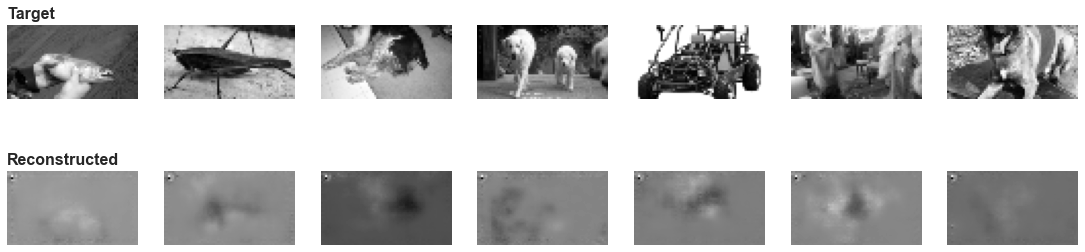

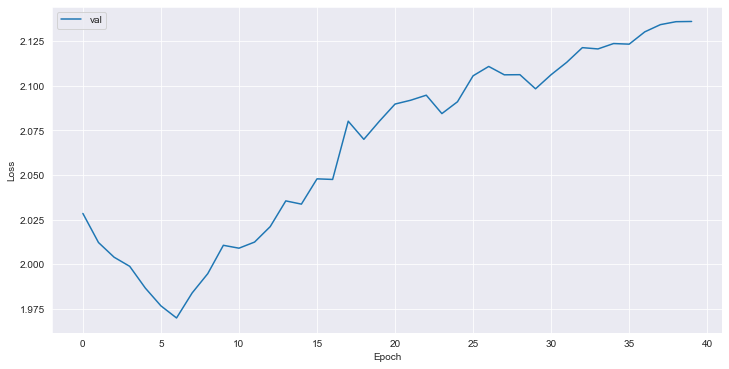

In [29]:
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"))

### plot reconstructions of the final model
decoder.core.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "G" in k or "D" in k})
decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "readin" in k})
stim_pred_best = decoder(
    resp.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
).detach().cpu()
plot_comparison(
    target=stim[:8].cpu(),
    pred=stim_pred_best[:8].cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)

In [ ]:
live_plot.draw()

In [ ]:
stim_training, resp_training = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[0]))
stim_training_pred_best = decoder(resp_training.to(config["device"]), data_key=sample_data_key).detach().cpu()
plot_comparison(
    target=stim_training[:8].cpu(),
    pred=stim_training_pred_best[:8].cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)